# 목차

### 1. 데이터 준비
### 2. 데이터 전처리
### 3. 시계열 분리
### 4. 훈련
### 5. 예측

이번 노드는 시계열에 대한 이론과 시계열 데이터를 처리하는 여러 방법에 대해 공부할 수 있는 노드였습니다. 시계열 데이터를 통한 이후의 시점을 예측하기 위해선 기본적으로 정상성이 전제되어야 합니다. 정상성을 노드에선 안정성이라는 표현으로 대체하고 있는데, 이는 다음의 세 가지 성질을 의미합니다.
* 평균이 시점에 상관없이 일정해야 한다.
* 분산이 시점에 상관없이 일정해야 한다.
* 공분산이 일정해야 한다.

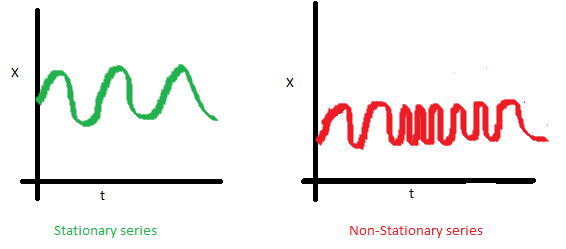
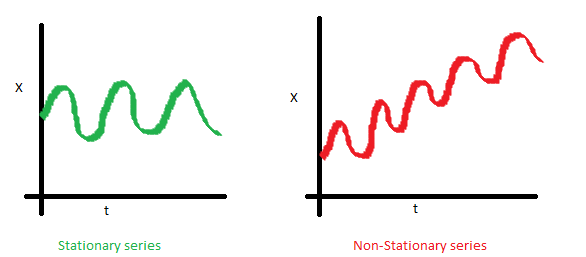
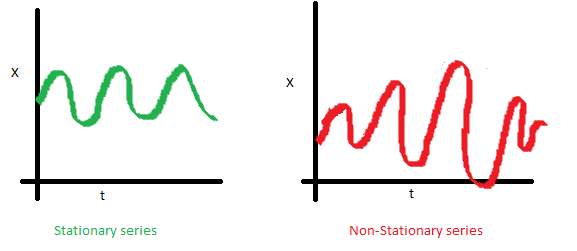

## 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams

In [2]:
# Time Series 생성
file_path = os.getenv("HOME")+"/aiffel/stock_prediction/data/316140.KS.csv"
data = pd.read_csv(file_path, encoding = "utf-8", index_col = "Date", parse_dates=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-21,15200.0,15250.0,15050.0,15100.0,14237.142578,883514.0
2019-02-22,14950.0,15000.0,14750.0,14850.0,14001.428711,1546763.0
2019-02-25,14900.0,15050.0,14850.0,14900.0,14048.571289,905856.0
2019-02-26,14900.0,14950.0,14700.0,14700.0,13860.000000,890582.0
2019-02-27,14650.0,14850.0,14500.0,14800.0,13954.286133,1573961.0
...,...,...,...,...,...,...
2021-02-24,9620.0,9780.0,9620.0,9660.0,9660.000000,2631640.0
2021-02-25,9710.0,9870.0,9670.0,9820.0,9820.000000,1898519.0
2021-02-26,9750.0,9790.0,9510.0,9580.0,9580.000000,2794858.0


In [3]:
ts = data['Close']
ts.head()

Date
2019-02-21    15100.0
2019-02-22    14850.0
2019-02-25    14900.0
2019-02-26    14700.0
2019-02-27    14800.0
Name: Close, dtype: float64

## 각종 전처리 수행

### 결측치 보간
* ts.interpolote()
  * default는 interpolate(method='values')로 선형으로 비례하여 결측값을 보간
  * ts.interpolate(method='time')는 시간의 흐름을 도입하여 변환

In [4]:
# 결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Date
2019-11-14   NaN
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


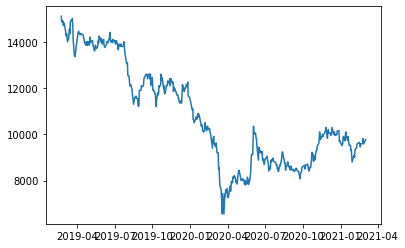

In [5]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

### 로그 변환

시계열이 정상성을 만족하지 못하더라도, 정상성을 띄는 데이터로 변형하여 분석에 활용할 수 있습니다. 크게 두 가지 방법이 있는데, 하나는 차분, 다른 하나는 자연로그를 취해주는 방법입니다. 


* 차분 : 평균의 정상화
* 로그변환 : 분산의 안정화

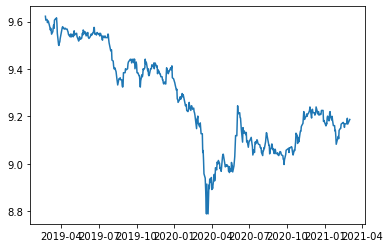

In [6]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


#### 로그 변환 전후의 p-value 비교
* statsmodels 패키지 - R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
* adfuller 패키지로 timeseries에 대한 Augmented Dickey-Fuller Test를 수행
  * 로그변환만으로 0.07의 변화를 보임
  * 보다 안정적 시계열로 변함

In [8]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.796349
p-value                          0.382276
#Lags Used                       3.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64


In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.601967
p-value                          0.482605
#Lags Used                       8.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64


### STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

#### 정성적 분석(통계적 특성을 좀 더 명료하게 시각화)
* 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
* 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


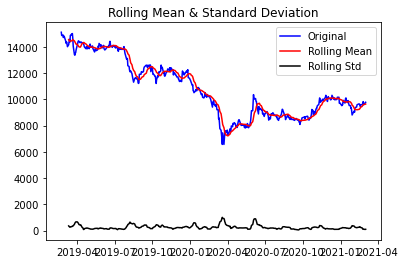

In [11]:
plot_rolling_statistics(ts, window=12)

#### 정량적 분석으로 수치적으로 판단할 수 있는 기준 제시
* statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 통계 패키지
* adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [13]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.601967
p-value                          0.482605
#Lags Used                       8.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64


In [14]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### 시계열 분해를 통해 안정적인 시계열을 분리
* Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지가 Residual
* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value

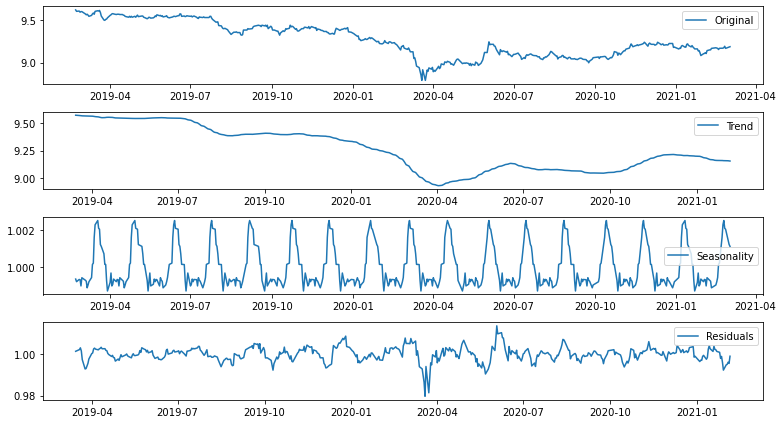

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

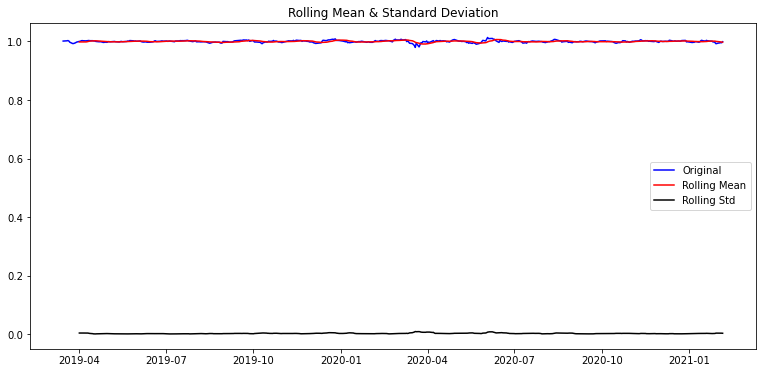

In [16]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.249159e+00
p-value                        1.798989e-10
#Lags Used                     9.000000e+00
Number of Observations Used    4.610000e+02
Critical Value (1%)           -3.444615e+00
Critical Value (5%)           -2.867830e+00
Critical Value (10%)          -2.570120e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리
* 학습 : 테스트 = 9 : 1

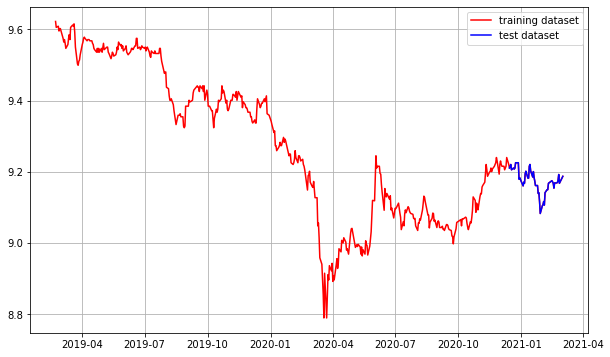

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [19]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2019-02-21    9.622450
2019-02-22    9.605755
Name: Close, dtype: float64
(450,)
(51,)


### STEP 5 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

#### ARIMA의 모수는 3가지
* 자기회귀 모형(AR)의 시차를 의미하는 p
* 차분(diffdrence) 횟수를 의미하는 d
* 이동평균 모형(MA)의 시차를 의미하는 q

* ACF를 통해 MA 모델의 시차 q를 결정
* PACF를 통해 AR 모델의 시차 p를 결정

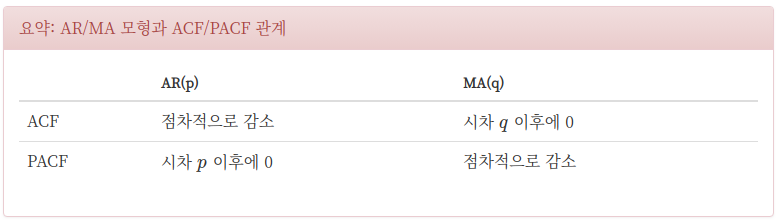

#### q 구하기

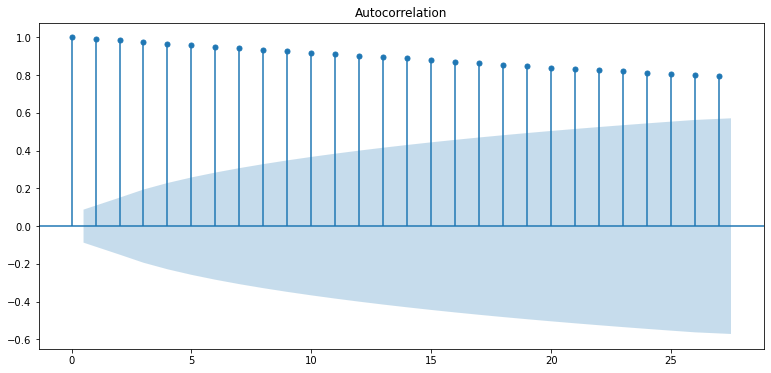

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plt.show()

#### p 구하기

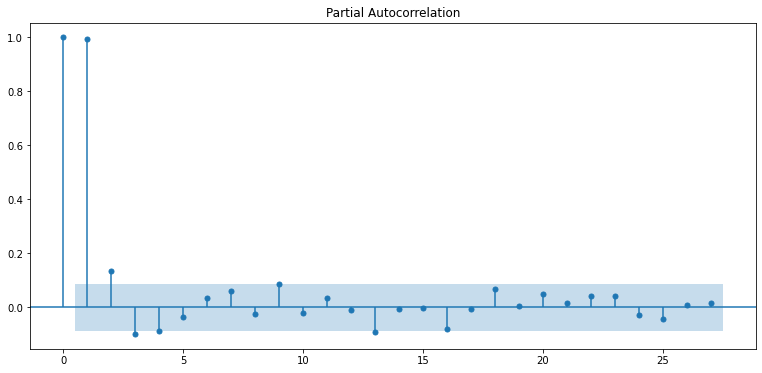

In [21]:
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 차분안정성 구하기

Results of Dickey-Fuller Test:
Test Statistic                -8.381504e+00
p-value                        2.502903e-13
#Lags Used                     7.000000e+00
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.074791e+01
p-value                        2.711902e-19
#Lags Used                     1.300000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


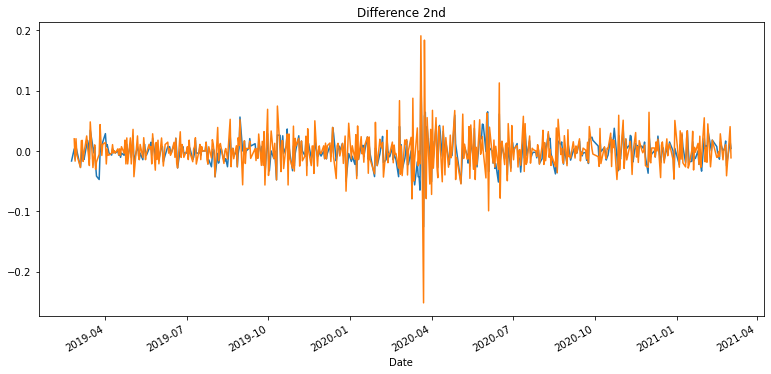

In [22]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)


In [23]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# 일반적으로 p+q < 2, p*q = 0
model = ARIMA(train_data, order=(1, 1, 0)) #p, d, q 
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  449
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1098.381
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 04 Mar 2021   AIC                          -2190.763
Time:                        00:54:17   BIC                          -2178.441
Sample:                             1   HQIC                         -2185.906
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0009      0.001     -1.032      0.302      -0.003       0.001
ar.L1.D.Close    -0.1535      0.047     -3.291      0.001      -0.245      -0.062
                                    Root

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

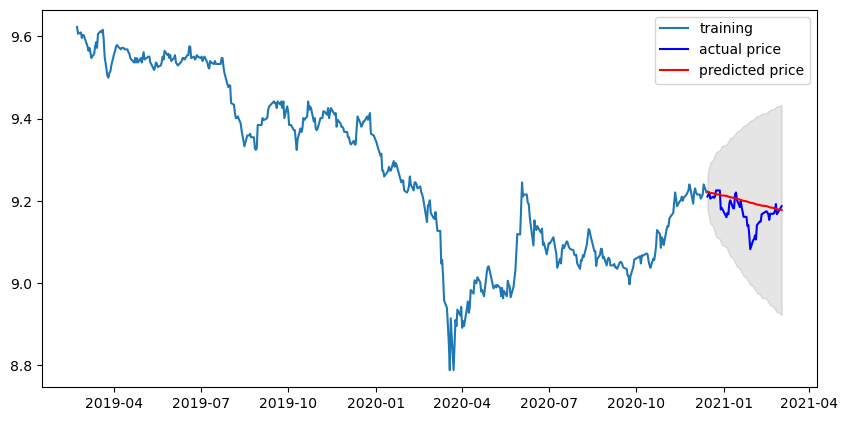

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  140101.44073290564
MAE:  279.02481132034364
RMSE:  374.30127001241345
MAPE: 2.98%


## 후기

#### 느낀점
이번 노드를 통해 시계열 데이터를 다루는 여러가지 방법에 대해 알 수 있었습니다. 코드 자체는 전체적으로 주어져 이해하기 어렵지 않았으나 개념적으로 이해하는 것이 다소 어려웠습니다. 새로운 개념과 통계적 개념등이 나왔기 때문에 이해하는데 다소 어려웠습니다. 아직 이해하지 못했지만 공부하는데 큰 도움이 될 것 같습니다.

#### 어려웠던 점
코드 자체는 어렵지 않았으나, 루브릭에 명시된 수치를 달성하는 것이 어려웠습니다. 시계열 예측의 성능을 평가하는 지표인 노드에서 언급한  MAPE를 낮추기 위해 시각화한 p, d, q를 수정해 보았습니다. 그래프로 그렸을 때는 대체적으로 1, 1, 0으로 나타났지만 오히려 수치를 조정하면 다소 하락하는 모습을 보였습니다. 그러나 삼성전자 데이터로 여러 수치를 실험해본 결과, 큰 차이를 보이지 않았습니다.
* 삼성전자
  * 1, 1, 0 - 19.59%
  * 2, 1, 0 - 19.48%
  * 3, 1, 0 - 19.43%

그래서 어떤 시계열의 데이터가 MAPE 수치가 적게 나오는지 확인하는 방향으로 방식을 틀어보았습니다. 그리고 이를 위해 해당 수치를 만족하는 다양한 주식을 찾아보았습니다.


* Rocket Companies, Inc. (RKT)
  * 8.77%
* Haitai Confectionery&Foods Co.,ltd. (101530.KS)
  * 9.28%
* Woori Financial Group Inc. (316140.KS)
  * 2.98%

위의 3가지 종목은 변화가 큰 폭으로 있지 않고 변동성이 다소 크지 않아 MAPE수치가 적게 나온 것으로 보입니다. 시계열의 그래프를 해석하고 예측을 올리는 방식에 대한 공부가 더 필요할 것으로 보입니다.